In [1]:
%%html
<style>
.output_subarea.output_text.output_stream.output_stdout > pre {
   width:max-content;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output > pre {
   width:max-content;
}
</style>

# Menu

# Librerias

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import sys
import plotly.graph_objs as go
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [3]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import Dense

/home/juan/Documentos/personal/tesis/bitcoin_trader/bt_kernel/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/juan/Documentos/personal/tesis/bitcoin_trader/bt_kernel/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/juan/Documentos/personal/tesis/bitcoin_trader/bt_kernel/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/juan/Documentos/personal/tesis/bitcoin_trader/bt_kernel/lib/python3.6/site-packages/tensorflow/python/f

# Parametros

In [4]:
graficas_path = "graficas/"

# Spark init

In [5]:
# from pyspark.sql import SparkSession
# from pyspark import SparkConf
# spark = SparkSession.builder.appName('ingesta_tweets').getOrCreate()

In [6]:
# from pyspark.sql import functions as F

# Primera prueba con LSTM

In [5]:
prices_dataframe = pd.read_csv("data/all_both_cryptocurrency.csv", parse_dates=["date"])
prices_dataframe["date"] = prices_dataframe.date.dt.date
prices_dataframe.sort_values(by=["date", "hour"], ascending=True, inplace=True)

In [6]:
full_raw_data = prices_dataframe.values

In [7]:
partition = 0.8
end_partition = int(np.floor(prices_dataframe.shape[0]*partition))

In [8]:
train_raw_data, test_raw_data = full_raw_data[:end_partition], full_raw_data[end_partition:]

# Simple LSTM

In [9]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()

In [12]:
prices_dataframe.columns

Index(['date', 'hour', 'close_btc', 'high_btc', 'low_btc', 'volume_btc',
       'volume_btc_usd', 'close_eth', 'high_eth', 'low_eth', 'volume_eth',
       'volume_eth_usd'],
      dtype='object')

In [10]:
train_close_data = train_raw_data[:,2].reshape(train_raw_data.shape[0],1)
test_close_data = test_raw_data[:,2].reshape(test_raw_data.shape[0],1)
full_close_data = full_raw_data[:,2].reshape(full_raw_data.shape[0],1)

In [11]:
datetime_fun = lambda d_h: dt.datetime(d_h[0].year, d_h[0].month, d_h[0].day, d_h[1])
time_series = prices_dataframe[["date","hour"]].apply(datetime_fun, axis=1)

In [12]:
model_sc1 = scl.fit(train_close_data)

In [13]:
full_close_data_scaled = model_sc1.transform(full_close_data)

In [17]:
# fig = plotly.subplots.make_subplots(rows=1, cols=2)
# fig.add_trace(
#     plotly.graph_objs.Line( name="Original", x=time_series, y=full_close_data[:,0]),
#     row=1,col=1
# )
# fig.add_trace(
#     plotly.graph_objs.Line( name="Transformado", x=time_series, y=full_close_data_scaled[:,0]),
#     row=1,col=2
# )
# # Add figure title
# fig.update_layout(
#     title_text="Original y transformación en scala min-max de la variable Close"
# )

# # Set x-axis title
# fig.update_xaxes(title_text="Fecha")

# # Set y-axes titles
# fig.update_yaxes(title_text="<b>Original</b> Close", row=1,col=1)
# fig.update_yaxes(title_text="<b>Transformación</b> Close", row=1,col=2)

# plotly.offline.plot(fig, filename="graficas/min_max_transformation.html")

In [14]:
batches_length = 32
hours_history_length = 24
epochs = 30

In [15]:
all_data_transformed = [[full_close_data_scaled[ind - hours_history_length:ind].reshape(hours_history_length).tolist(),( float(full_close_data[ind][0]/full_close_data[ind-1][0])-1)] for ind in range(hours_history_length,full_close_data.shape[0])]

In [16]:
full_zipped = np.array([[full_close_data_scaled[ind],(full_close_data[ind+1]/full_close_data[ind]) - 1] for ind in range(len(full_close_data)-1)])

In [17]:
data_full = np.array([
            full_zipped[ind-hours_history_length:ind]
            for ind in range(hours_history_length,len(full_zipped))
                  ])
x_full = data_full[:,:,0]
y_full = data_full[:,:,1]

In [18]:
X_train = (x_full[:train_close_data.shape[0] - hours_history_length]).astype("float")
Y_train = (y_full[:train_close_data.shape[0] - hours_history_length]).astype("float")
X_test = (x_full[train_close_data.shape[0] - hours_history_length:]).astype("float")
Y_test = (y_full[train_close_data.shape[0] - hours_history_length:]).astype("float")

# statefuless

In [23]:
from tensorflow.python.keras import models, layers

def define_model(len_ts,
                 hidden_neurons = 10,
                 nfeature=1,
                 batch_size=None,
                 stateful=False):
    in_out_neurons = 1
    
    inp = layers.Input(batch_shape= (batch_size, len_ts, nfeature),
                       )  

    rnn = layers.LSTM( hidden_neurons, 
                      dropout=0.2,
                    return_sequences=True,
                    stateful=stateful,
                    )(inp)

    dens = layers.Dense(in_out_neurons)(rnn)
    model = models.Model(inputs=[inp],outputs=[dens])
    
    model.compile(loss="mean_squared_error",
                  optimizer="rmsprop", metrics=['mse'])

    return(model,(inp,rnn,dens))

In [24]:
hunits = 256
model_stateless, _ = define_model(
                    hidden_neurons = hunits,
                    len_ts = X_train.shape[1])
model_stateless.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24, 1)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 24, 256)           264192    
_________________________________________________________________
dense (Dense)                (None, 24, 1)             257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


In [25]:
import time
start = time.time()
history = model_stateless.fit(X_train,Y_train,
                             batch_size=24,
                             epochs=300,
                             verbose=2,
                             validation_data=(X_test,Y_test))
end = time.time()
print("Time Took :{:3.2f} min".format( (end-start)/60 ))

Train on 14578 samples, validate on 3650 samples
Epoch 1/300
 - 16s - loss: 2.1796e-04 - mean_squared_error: 2.1796e-04 - val_loss: 7.7897e-05 - val_mean_squared_error: 7.7897e-05
Epoch 2/300
 - 15s - loss: 1.0731e-04 - mean_squared_error: 1.0731e-04 - val_loss: 7.7697e-05 - val_mean_squared_error: 7.7697e-05
Epoch 3/300
 - 15s - loss: 1.0602e-04 - mean_squared_error: 1.0602e-04 - val_loss: 8.1431e-05 - val_mean_squared_error: 8.1431e-05
Epoch 4/300
 - 15s - loss: 1.0561e-04 - mean_squared_error: 1.0561e-04 - val_loss: 7.7038e-05 - val_mean_squared_error: 7.7038e-05
Epoch 5/300
 - 15s - loss: 1.0545e-04 - mean_squared_error: 1.0545e-04 - val_loss: 7.6533e-05 - val_mean_squared_error: 7.6533e-05
Epoch 6/300
 - 15s - loss: 1.0537e-04 - mean_squared_error: 1.0537e-04 - val_loss: 7.6546e-05 - val_mean_squared_error: 7.6546e-05
Epoch 7/300
 - 15s - loss: 1.0537e-04 - mean_squared_error: 1.0537e-04 - val_loss: 7.6491e-05 - val_mean_squared_error: 7.6491e-05
Epoch 8/300
 - 15s - loss: 1.0537e

Epoch 63/300
 - 16s - loss: 1.0530e-04 - mean_squared_error: 1.0530e-04 - val_loss: 7.6504e-05 - val_mean_squared_error: 7.6504e-05
Epoch 64/300
 - 15s - loss: 1.0531e-04 - mean_squared_error: 1.0531e-04 - val_loss: 7.7272e-05 - val_mean_squared_error: 7.7272e-05
Epoch 65/300
 - 15s - loss: 1.0529e-04 - mean_squared_error: 1.0529e-04 - val_loss: 7.7278e-05 - val_mean_squared_error: 7.7278e-05
Epoch 66/300
 - 15s - loss: 1.0530e-04 - mean_squared_error: 1.0530e-04 - val_loss: 7.6745e-05 - val_mean_squared_error: 7.6745e-05
Epoch 67/300
 - 15s - loss: 1.0531e-04 - mean_squared_error: 1.0531e-04 - val_loss: 7.6476e-05 - val_mean_squared_error: 7.6476e-05
Epoch 68/300
 - 15s - loss: 1.0530e-04 - mean_squared_error: 1.0530e-04 - val_loss: 7.6734e-05 - val_mean_squared_error: 7.6734e-05
Epoch 69/300
 - 15s - loss: 1.0529e-04 - mean_squared_error: 1.0529e-04 - val_loss: 7.6482e-05 - val_mean_squared_error: 7.6482e-05
Epoch 70/300
 - 15s - loss: 1.0529e-04 - mean_squared_error: 1.0529e-04 - va

Epoch 125/300
 - 15s - loss: 1.0530e-04 - mean_squared_error: 1.0530e-04 - val_loss: 7.7057e-05 - val_mean_squared_error: 7.7057e-05
Epoch 126/300
 - 15s - loss: 1.0527e-04 - mean_squared_error: 1.0527e-04 - val_loss: 7.7596e-05 - val_mean_squared_error: 7.7596e-05
Epoch 127/300
 - 15s - loss: 1.0531e-04 - mean_squared_error: 1.0531e-04 - val_loss: 7.6624e-05 - val_mean_squared_error: 7.6624e-05
Epoch 128/300
 - 15s - loss: 1.0529e-04 - mean_squared_error: 1.0529e-04 - val_loss: 7.6464e-05 - val_mean_squared_error: 7.6464e-05
Epoch 129/300
 - 15s - loss: 1.0528e-04 - mean_squared_error: 1.0528e-04 - val_loss: 7.8353e-05 - val_mean_squared_error: 7.8353e-05
Epoch 130/300
 - 15s - loss: 1.0528e-04 - mean_squared_error: 1.0528e-04 - val_loss: 7.8242e-05 - val_mean_squared_error: 7.8242e-05
Epoch 131/300
 - 15s - loss: 1.0527e-04 - mean_squared_error: 1.0527e-04 - val_loss: 7.9540e-05 - val_mean_squared_error: 7.9540e-05
Epoch 132/300
 - 15s - loss: 1.0527e-04 - mean_squared_error: 1.0527e

Epoch 187/300
 - 15s - loss: 1.0528e-04 - mean_squared_error: 1.0528e-04 - val_loss: 7.6731e-05 - val_mean_squared_error: 7.6731e-05
Epoch 188/300
 - 15s - loss: 1.0527e-04 - mean_squared_error: 1.0527e-04 - val_loss: 7.6845e-05 - val_mean_squared_error: 7.6845e-05
Epoch 189/300
 - 15s - loss: 1.0528e-04 - mean_squared_error: 1.0528e-04 - val_loss: 7.7419e-05 - val_mean_squared_error: 7.7419e-05
Epoch 190/300
 - 15s - loss: 1.0525e-04 - mean_squared_error: 1.0525e-04 - val_loss: 7.9246e-05 - val_mean_squared_error: 7.9246e-05
Epoch 191/300
 - 15s - loss: 1.0524e-04 - mean_squared_error: 1.0524e-04 - val_loss: 7.8454e-05 - val_mean_squared_error: 7.8454e-05
Epoch 192/300
 - 15s - loss: 1.0526e-04 - mean_squared_error: 1.0526e-04 - val_loss: 7.7390e-05 - val_mean_squared_error: 7.7390e-05
Epoch 193/300
 - 15s - loss: 1.0527e-04 - mean_squared_error: 1.0527e-04 - val_loss: 7.8063e-05 - val_mean_squared_error: 7.8063e-05
Epoch 194/300
 - 15s - loss: 1.0524e-04 - mean_squared_error: 1.0524e

Epoch 249/300
 - 15s - loss: 1.0530e-04 - mean_squared_error: 1.0530e-04 - val_loss: 7.6482e-05 - val_mean_squared_error: 7.6482e-05
Epoch 250/300
 - 15s - loss: 1.0526e-04 - mean_squared_error: 1.0526e-04 - val_loss: 7.6714e-05 - val_mean_squared_error: 7.6714e-05
Epoch 251/300
 - 15s - loss: 1.0523e-04 - mean_squared_error: 1.0523e-04 - val_loss: 7.6464e-05 - val_mean_squared_error: 7.6464e-05
Epoch 252/300
 - 15s - loss: 1.0529e-04 - mean_squared_error: 1.0529e-04 - val_loss: 7.6843e-05 - val_mean_squared_error: 7.6843e-05
Epoch 253/300
 - 15s - loss: 1.0526e-04 - mean_squared_error: 1.0526e-04 - val_loss: 7.6482e-05 - val_mean_squared_error: 7.6482e-05
Epoch 254/300
 - 15s - loss: 1.0526e-04 - mean_squared_error: 1.0526e-04 - val_loss: 7.6729e-05 - val_mean_squared_error: 7.6729e-05
Epoch 255/300
 - 15s - loss: 1.0525e-04 - mean_squared_error: 1.0525e-04 - val_loss: 7.8006e-05 - val_mean_squared_error: 7.8006e-05
Epoch 256/300
 - 15s - loss: 1.0525e-04 - mean_squared_error: 1.0525e

In [34]:
model_stateless.test_on_batch(X_test[0], y=Y_test)

[7.712059e-05, 7.7120596e-05]

In [43]:
y_pred = model_stateless.predict_on_batch(np.array([X_test[0]]))

In [44]:
y_pred

array([[[0.00115169],
        [0.00123576],
        [0.00124663],
        [0.00123527],
        [0.0012394 ],
        [0.0012478 ],
        [0.00124239],
        [0.00122809],
        [0.00122089],
        [0.0012269 ],
        [0.00123878],
        [0.00124613],
        [0.00124447],
        [0.00123672],
        [0.00122945],
        [0.00122756],
        [0.00123145],
        [0.00123769],
        [0.00124189],
        [0.00124111],
        [0.00123617],
        [0.00123097],
        [0.00122907],
        [0.00123121]]], dtype=float32)

In [45]:
Y_test[0]

array([[-1.53729590e-03],
       [-7.26387537e-04],
       [ 7.67322409e-04],
       [ 2.24837617e-03],
       [-8.21965415e-04],
       [ 9.12999420e-04],
       [-1.00503048e-03],
       [ 2.61248319e-06],
       [ 1.95614522e-04],
       [ 2.16339248e-03],
       [ 5.16138184e-05],
       [ 1.06576180e-03],
       [-5.76806416e-05],
       [-8.68887455e-04],
       [-8.73594543e-06],
       [ 1.88713021e-03],
       [ 7.32635484e-04],
       [-1.26089774e-03],
       [ 3.39692829e-03],
       [ 1.63525291e-03],
       [-1.98186006e-04],
       [-1.08342498e-03],
       [-1.77529466e-04],
       [ 3.47937919e-05]])

In [42]:
np.array([X_test[0]])

array([[[0.11131175],
        [0.11098369],
        [0.11082891],
        [0.11099229],
        [0.11147138],
        [0.11129584],
        [0.11149066],
        [0.11127601],
        [0.11127657],
        [0.1113183 ],
        [0.11177999],
        [0.11179103],
        [0.11201898],
        [0.11200663],
        [0.1118206 ],
        [0.11181873],
        [0.11222241],
        [0.11237942],
        [0.112109  ],
        [0.11283662],
        [0.11318808],
        [0.11314541],
        [0.11291222],
        [0.11287405]]])

In [39]:
X_test

array([[[0.11131175],
        [0.11098369],
        [0.11082891],
        ...,
        [0.11314541],
        [0.11291222],
        [0.11287405]],

       [[0.11098369],
        [0.11082891],
        [0.11099229],
        ...,
        [0.11291222],
        [0.11287405],
        [0.11288153]],

       [[0.11082891],
        [0.11099229],
        [0.11147138],
        ...,
        [0.11287405],
        [0.11288153],
        [0.11200663]],

       ...,

       [[0.4335818 ],
        [0.43610772],
        [0.43568158],
        ...,
        [0.46112542],
        [0.45853888],
        [0.45925117]],

       [[0.43610772],
        [0.43568158],
        [0.43645449],
        ...,
        [0.45853888],
        [0.45925117],
        [0.46060946]],

       [[0.43568158],
        [0.43645449],
        [0.4431809 ],
        ...,
        [0.45925117],
        [0.46060946],
        [0.46208961]]])

In [27]:
y_pred

array([[[0.00115169],
        [0.00123576],
        [0.00124663],
        ...,
        [0.00123097],
        [0.00122907],
        [0.00123121]],

       [[0.00115178],
        [0.00123591],
        [0.00124665],
        ...,
        [0.00123106],
        [0.00122923],
        [0.00123126]],

       [[0.00115183],
        [0.00123592],
        [0.00124648],
        ...,
        [0.00123122],
        [0.00122927],
        [0.00123148]],

       ...,

       [[0.00106273],
        [0.00103693],
        [0.00103487],
        ...,
        [0.00103876],
        [0.00103933],
        [0.0010396 ]],

       [[0.00106206],
        [0.00103614],
        [0.00103466],
        ...,
        [0.00103905],
        [0.0010399 ],
        [0.0010395 ]],

       [[0.00106217],
        [0.00103608],
        [0.00103252],
        ...,
        [0.0010396 ],
        [0.00103979],
        [0.0010387 ]]], dtype=float32)

In [33]:
fig = plotly.subplots.make_subplots(rows=1, cols=1)
fig.add_trace(
    plotly.graph_objs.Line( name="Original", x=list(range(len(Y_test[:,-1,0]))), y=Y_test[:,-1,0])
)
fig.add_trace(
    plotly.graph_objs.Line( name="Transformado", x=list(range(len(y_pred[:,-1,0]))), y=y_pred[:,-1,0])
)
# Add figure title
fig.update_layout(
    title_text="Original y transformación en scala min-max de la variable Close"
)

# Set x-axis title
fig.update_xaxes(title_text="Fecha")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Original</b> Close", row=1,col=1)
fig.update_yaxes(title_text="<b>Transformación</b> Close", row=1,col=2)

plotly.offline.plot(fig, filename="graficas/predictions_basic.html")

/home/juan/Documentos/tesis/bitcoin_trader/bt_kernel/lib/python3.5/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




'graficas/predictions_basic.html'

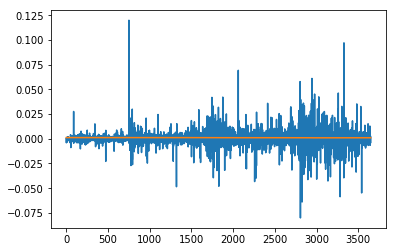

In [29]:
from matplotlib import pyplot as plt
plt.plot(Y_test[:,-1,0])
plt.plot(y_pred[:,-1,0])
plt.show()

In [97]:
X_test.shape

(3650, 24, 1)

In [99]:
3650  + 14578

18228

In [93]:
x_full.shape

(18228, 24, 1)

In [52]:
len(Y_zipped)

18228

In [59]:
X_train[:2]

array([[0.0383442 , 0.03755781, 0.03542172, 0.03576532, 0.03624779,
        0.03601254, 0.0351032 , 0.03368631, 0.03445006, 0.03241559,
        0.0329673 , 0.03333935, 0.03319674, 0.03146564, 0.032465  ,
        0.03210044, 0.03250187, 0.03254098, 0.03423297, 0.03310729,
        0.03422979, 0.03527406, 0.03496864, 0.03406117],
       [0.03755781, 0.03542172, 0.03576532, 0.03624779, 0.03601254,
        0.0351032 , 0.03368631, 0.03445006, 0.03241559, 0.0329673 ,
        0.03333935, 0.03319674, 0.03146564, 0.032465  , 0.03210044,
        0.03250187, 0.03254098, 0.03423297, 0.03310729, 0.03422979,
        0.03527406, 0.03496864, 0.03406117, 0.03477008]])

In [60]:
Y_train[:2]

array([[-0.00559965, -0.01529614,  0.00249869,  0.00349979, -0.00170052,
        -0.00658448, -0.0103276 ,  0.00562498, -0.01490002,  0.00410174,
         0.00275469, -0.00105303, -0.01279563,  0.00748262, -0.00270932,
         0.00299145,  0.00029058,  0.01256749, -0.00825737,  0.0083026 ,
         0.00766043, -0.00222345, -0.00662096,  0.00520673],
       [-0.01529614,  0.00249869,  0.00349979, -0.00170052, -0.00658448,
        -0.0103276 ,  0.00562498, -0.01490002,  0.00410174,  0.00275469,
        -0.00105303, -0.01279563,  0.00748262, -0.00270932,  0.00299145,
         0.00029058,  0.01256749, -0.00825737,  0.0083026 ,  0.00766043,
        -0.00222345, -0.00662096,  0.00520673, -0.00468888]])

In [50]:
len(all_data_transformed)

18229

In [57]:
len(X_train)

14578

In [58]:
len(X_test)

3650

In [56]:
3650 + 14578

18228

In [49]:
len(X_train)

14578

In [22]:
def get_x_y(data):
    return np.array([x[0] for x in data]), np.array([x[1] for x in data])

In [23]:
data_x, data_y = get_x_y(data_to_train)

In [24]:
data_x_test, data_y_test = get_x_y(data_to_test)

In [24]:
data_x.shape

(14578, 24)

In [25]:
data_x_lstm_train = data_x.reshape(*data_x.shape,1)
data_x_lstm_test = data_x_test.reshape(*data_x_test.shape,1)
data_y_lstm_train = data_y.reshape(*data_y.shape,1)
data_y_lstm_test = data_y_test.reshape(*data_y_test.shape,1)

## Construyendo el modelo

In [26]:
max_len = 24
batch_size = 1
print('Build STATEFUL model...')
model = Sequential()
model.add(LSTM(256, batch_input_shape=(1, 1, 1), return_sequences=False, stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

Build STATEFUL model...


In [27]:
print('Train...')
max_len = 24
for epoch in range(30):
    mean_tr_acc = []
    mean_tr_loss = []
    for i in range(len(data_x_lstm_train)):
        y_true = data_y_lstm_train[i]
        for j in range(max_len):
            tr_loss, tr_acc = model.train_on_batch(np.expand_dims(np.expand_dims(data_x_lstm_train[i][j], axis=1), axis=1),
                                                   np.array([y_true]))
            mean_tr_acc.append(tr_acc)
            mean_tr_loss.append(tr_loss)
        model.reset_states()

    print('accuracy training = {}'.format(np.mean(mean_tr_acc)))
    print('loss training = {}'.format(np.mean(mean_tr_loss)))
    print('___________________________________')

    mean_te_acc = []
    mean_te_loss = []
    for i in range(len(data_x_lstm_test)):
        for j in range(max_len):
            te_loss, te_acc = model.test_on_batch(np.expand_dims(np.expand_dims(data_x_lstm_test[i][j], axis=1), axis=1),
                                                  data_y_lstm_test[i])
            mean_te_acc.append(te_acc)
            mean_te_loss.append(te_loss)
        model.reset_states()

        for j in range(max_len):
            y_pred = model.predict_on_batch(np.expand_dims(np.expand_dims(data_x_lstm_test[i][j], axis=1), axis=1))
        model.reset_states()

    print('accuracy testing = {}'.format(np.mean(mean_te_acc)))
    print('loss testing = {}'.format(np.mean(mean_te_loss)))
    print('___________________________________')

Train...
accuracy training = 9.909360960591584e-05
loss training = 9.909360960591584e-05
___________________________________


ValueError: Error when checking target: expected dense to have 2 dimensions, but got array with shape ()

In [28]:
predictions = []
for i in range(len(data_x_lstm_test)):
        y_pred = None
        for j in range(max_len):
            y_pred = model.predict_on_batch(np.expand_dims(np.expand_dims(data_x_lstm_test[i][j], axis=1), axis=1))
        predictions.append(y_pred)
        model.reset_states()

In [31]:
data_x_lstm_test

array([[[0.11131175],
        [0.11098369],
        [0.11082891],
        ...,
        [0.11314541],
        [0.11291222],
        [0.11287405]],

       [[0.11098369],
        [0.11082891],
        [0.11099229],
        ...,
        [0.11291222],
        [0.11287405],
        [0.11288153]],

       [[0.11082891],
        [0.11099229],
        [0.11147138],
        ...,
        [0.11287405],
        [0.11288153],
        [0.11200663]],

       ...,

       [[0.43610772],
        [0.43568158],
        [0.43645449],
        ...,
        [0.45853888],
        [0.45925117],
        [0.46060946]],

       [[0.43568158],
        [0.43645449],
        [0.4431809 ],
        ...,
        [0.45925117],
        [0.46060946],
        [0.46208961]],

       [[0.43645449],
        [0.4431809 ],
        [0.44300368],
        ...,
        [0.46060946],
        [0.46208961],
        [0.46004802]]])

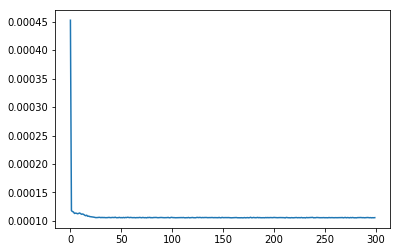

In [29]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.show()

In [30]:
data_y_pr = d_model.predict(data_x_test.reshape(data_x_test.shape[0], hours_history_length, 1))

In [31]:
data_y_pr

array([[0.00067789],
       [0.00067791],
       [0.00067846],
       ...,
       [0.00037114],
       [0.00037033],
       [0.00037055]], dtype=float32)

In [32]:
data_y_pr

array([[0.00067789],
       [0.00067791],
       [0.00067846],
       ...,
       [0.00037114],
       [0.00037033],
       [0.00037055]], dtype=float32)

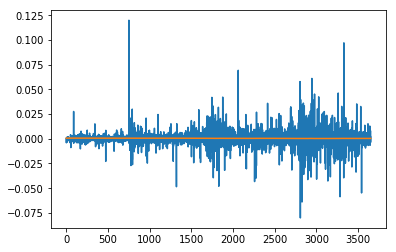

In [33]:
plt.plot(data_y_test)
plt.plot(data_y_pr)

In [127]:
x_data = np.array(data_to_train)[:,0]

In [137]:
np.array(list([(x) for x in bg] for bg in np.array(data_to_train)[:,1])).shape

SyntaxError: invalid syntax (<ipython-input-137-978927435a41>, line 1)

In [125]:
np.array(x_data)[0].ca

dtype('float64')

In [49]:
data_to_train[:,0][0].shape

(24,)

# Anexo

In [92]:
plotly.offline.plot({
"data": [
        plotly.graph_objs.Line( name="High", x=result_pandas["datetime"], y=result_pandas["high_btc"]),
        plotly.graph_objs.Line( name="Close", x=result_pandas["datetime"], y=result_pandas["close_btc"])
,
    
    plotly.graph_objs.Line(name = "Low", x=result_pandas["datetime"], y=result_pandas["low_btc"])
],
'layout': {'title': 'Volumen de tweets en periodo 2016-01 a 2019-08'}
}, filename=graficas_path+"/bitcoin_dataframe.html")

/home/juan/Documentos/personal/tesis/bitcoin_trader/bt_kernel/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




'graficas//bitcoin_dataframe.html'

## Mezclando ambas partes

In [19]:
start_date = dt.date(2017,7,1)
end_date= dt.date(2019,8,1)
crypto_dataframe = result_pandas[(result_pandas["datetime"]>=start_date) & (result_pandas["datetime"] <=end_date)]
tw_dataframe = day_count_dataframe[(day_count_dataframe["date"]>=start_date) & (day_count_dataframe["date"] <=end_date)]
plotly.offline.plot({
"data": [
        plotly.graph_objs.Line( name="High", x=crypto_dataframe["datetime"], y=crypto_dataframe["high_btc"]),
        plotly.graph_objs.Line( name="Close", x=crypto_dataframe["datetime"], y=crypto_dataframe["close_btc"]),   
        plotly.graph_objs.Line(name = "Low", x=crypto_dataframe["datetime"], y=crypto_dataframe["low_btc"]),
    
        plotly.graph_objs.Bar( x=tw_dataframe["date"], y=tw_dataframe["count"])

],
'layout': {'title': 'Volumen de tweets en periodo 2017-07 a 2019-08'}
}, filename=graficas_path+"/bitcoin_twitter.html")


/home/juan/Documentos/tesis/bitcoin_trader/bt_kernel/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning:

Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.

/home/juan/Documentos/tesis/bitcoin_trader/bt_kernel/lib/python3.5/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




'graficas//bitcoin_twitter.html'

In [20]:
crypto_dataframe.count()

date              18252
hour              18252
close_btc         18252
high_btc          18252
low_btc           18252
volume_btc        18252
volume_btc_usd    18252
close_eth         18252
high_eth          18252
low_eth           18252
volume_eth        18252
volume_eth_usd    18252
datetime          18252
dtype: int64